/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/magali/lib/python3.12/site-pac

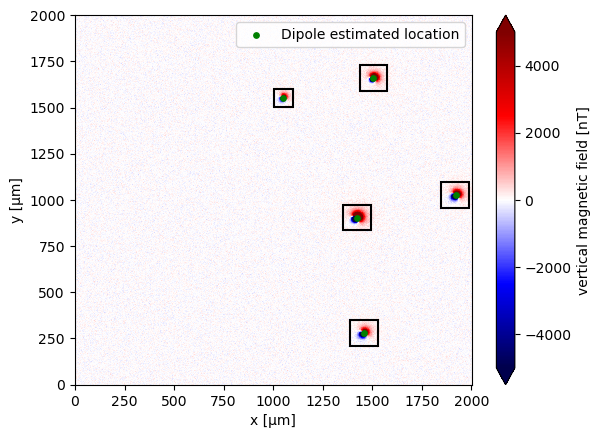

In [3]:
import numpy as np
import magali as mg
import harmonica as hm
import skimage.exposure
import xarray as xr
import matplotlib.pyplot as plt
import ensaio

SEED = 42
rng = np.random.default_rng(SEED)

sensor_sample_distance = 5.0
region = [0, 2000, 0, 2000]
spacing = 2.0
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5
size = 5

directions_inclination, directions_declination = mg.random_directions(
true_inclination,
true_declination,
true_dispersion_angle,
size=size,
random_state=SEED,
)

dipoles_amplitude = abs(rng.normal(0, 100, size)) * 1.0e-14
dipole_coordinates = (
rng.integers(30, 1970, size),
rng.integers(30, 1970, size),
rng.integers(-10, -1, size),
)

dipole_moments = hm.magnetic_angles_to_vec(
inclination=directions_inclination,
declination=directions_declination,
intensity=dipoles_amplitude,
)

data = mg.dipole_bz_grid(
region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
noise_std_dev = 100
data.values += rng.normal(loc=0, scale=noise_std_dev, size=data.shape)

height_difference = 5.0

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"], data_up["dy"], data_up["dz"], data_up["tga"] = dx, dy, dz, tga

stretched = skimage.exposure.rescale_intensity(
    tga, in_range=tuple(np.percentile(tga, (1, 99)))
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

bounding_boxes = mg.detect_anomalies(
    data_tga_stretched,
    size_range=[20, 150],
    detection_threshold=0.2,
    border_exclusion=2,
)

data_updated, locations_, dipole_moments_, r2_values = mg.iterative_nonlinear_inversion(
    data_up,
    bounding_boxes,
    height_difference=height_difference,
    copy_data=True,
)

fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(bounding_boxes, ax=ax, color="black", linewidth=1.5)
locations_arr = np.array(locations_)
ax.scatter(
    locations_arr[:, 0],  # x
    locations_arr[:, 1],  # y
    c="green",
    marker=".",
    s=60,
    label="Dipole estimated location"
)
plt.legend()
plt.show()